<a href="https://colab.research.google.com/github/inuwamobarak/semantic-segmentation/blob/main/Image_Semantic_Segmentation_using_Depth_Prediction_Transformers_(DPTs).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set-up Environment

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 92.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.7 MB/s eta 0:00:00


## Model Definition

In [ ]:
## Define model

# Import the DPTForSemanticSegmentation class from the transformers library
from transformers import DPTForSemanticSegmentation

# Create an instance of the DPTForSemanticSegmentation model and load the pretrained weights
# The "Intel/dpt-large-ade" model is used here, which is a large-scale model trained on the ADE20K dataset
model = DPTForSemanticSegmentation.from_pretrained("Intel/dpt-large-ade")

Some weights of DPTForSemanticSegmentation were not initialized from the model checkpoint at Intel/dpt-large-ade and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.batch_norm1.bias', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.running_var', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.running_mean', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm1.running_var', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.num_batches_tracked', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.bias', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm1.running_mean', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.weight', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm1.num_batches_tracked', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight']
You should probably TRAIN this mo

## Image Data Preparation

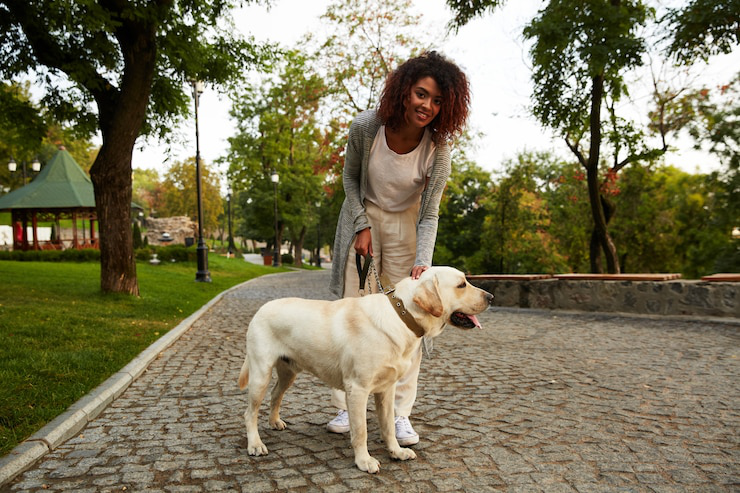

In [ ]:
# Import the Image class from the PIL (Python Imaging Library) module
from PIL import Image

# Import the requests module to make HTTP requests
import requests

# URL of the image to be downloaded
url = 'https://img.freepik.com/free-photo/happy-lady-hugging-her-white-friendly-dog-while-walking-park_171337-19281.jpg?w=740&t=st=1689214254~exp=1689214854~hmac=a8de6eb251268aec16ed61da3f0ffb02a6137935a571a4a0eabfc959536b03dd'

# Use the requests module to make an HTTP GET request to download the image
# The `stream=True` parameter ensures that the response is not immediately downloaded, but is kept in memory
response = requests.get(url, stream=True)

# Create an instance of the Image class from the raw image data obtained from the HTTP response
image = Image.open(response.raw)

# Display or further process the image as needed
image


In [ ]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

# Set the desired height and width for the input image
net_h = net_w = 480

# Define a series of image transformations using the Compose class from torchvision.transforms
transform = Compose([
        # Resize the image to the desired height and width
        Resize((net_h, net_w)),
        # Convert the image to a PyTorch tensor
        ToTensor(),
        # Normalize the image by subtracting the mean and dividing by the standard deviation
        Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

## Applying Image Transform

In [ ]:
# Apply the defined transformation to the input image
pixel_values = transform(image)

# Add an extra dimension to the tensor to create a batch of size 1
pixel_values = pixel_values.unsqueeze(0)

## Forward Pass

In [ ]:
import torch

# Use the torch.no_grad() context manager to disable gradient computation
with torch.no_grad():
    # Perform a forward pass through the model
    outputs = model(pixel_values)
    # Obtain the logits (raw predictions) from the output
    logits = outputs.logits

## Visualization

In [ ]:
# Print the shape of the logits tensor
print(logits.shape)

torch.Size([1, 150, 480, 480])

In [ ]:
import torch

# Interpolate the logits to the original image size
prediction = torch.nn.functional.interpolate(
    logits,
    size=image.size[::-1],  # Reverse the size of the original image (width, height)
    mode="bicubic",
    align_corners=False
)

# Convert the interpolated logits to class predictions
prediction = torch.argmax(prediction, dim=1) + 1

# Squeeze the prediction tensor to remove the extra dimensions
prediction = prediction.squeeze()

# Move the prediction tensor to the CPU and convert it to a numpy array
prediction = prediction.cpu().numpy()

array([[5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5],
       ...,
       [4, 4, 4, ..., 7, 7, 7],
       [4, 4, 4, ..., 7, 7, 7],
       [4, 4, 4, ..., 7, 7, 7]])

## Segmentation Prediction

In [ ]:
# Define the ADE20K palette
adepallete = [0,0,0,120,120,120,180,120,120,6,230,230,80,50,50,4,200,3,120,120,80,140,140,140,204,5,255,230,230,230,4,250,7,224,5,255,235,255,7,150,5,61,120,120,70,8,255,51,255,6,82,143,255,140,204,255,4,255,51,7,204,70,3,0,102,200,61,230,250,255,6,51,11,102,255,255,7,71,255,9,224,9,7,230,220,220,220,255,9,92,112,9,255,8,255,214,7,255,224,255,184,6,10,255,71,255,41,10,7,255,255,224,255,8,102,8,255,255,61,6,255,194,7,255,122,8,0,255,20,255,8,41,255,5,153,6,51,255,235,12,255,160,150,20,0,163,255,140,140,140,250,10,15,20,255,0,31,255,0,255,31,0,255,224,0,153,255,0,0,0,255,255,71,0,0,235,255,0,173,255,31,0,255,11,200,200,255,82,0,0,255,245,0,61,255,0,255,112,0,255,133,255,0,0,255,163,0,255,102,0,194,255,0,0,143,255,51,255,0,0,82,255,0,255,41,0,255,173,10,0,255,173,255,0,0,255,153,255,92,0,255,0,255,255,0,245,255,0,102,255,173,0,255,0,20,255,184,184,0,31,255,0,255,61,0,71,255,255,0,204,0,255,194,0,255,82,0,10,255,0,112,255,51,0,255,0,194,255,0,122,255,0,255,163,255,153,0,0,255,10,255,112,0,143,255,0,82,0,255,163,255,0,255,235,0,8,184,170,133,0,255,0,255,92,184,0,255,255,0,31,0,184,255,0,214,255,255,0,112,92,255,0,0,224,255,112,224,255,70,184,160,163,0,255,153,0,255,71,255,0,255,0,163,255,204,0,255,0,143,0,255,235,133,255,0,255,0,235,245,0,255,255,0,122,255,245,0,10,190,212,214,255,0,0,204,255,20,0,255,255,255,0,0,153,255,0,41,255,0,255,204,41,0,255,41,255,0,173,0,255,0,245,255,71,0,255,122,0,255,0,255,184,0,92,255,184,255,0,0,133,255,255,214,0,25,194,194,102,255,0,92,0,255]

In [ ]:
from PIL import Image

# Convert the prediction array to an image
predicted_seg = Image.fromarray(prediction.squeeze().astype('uint8'))

# Apply the color map to the predicted segmentation image
predicted_seg.putpalette(adepallete)

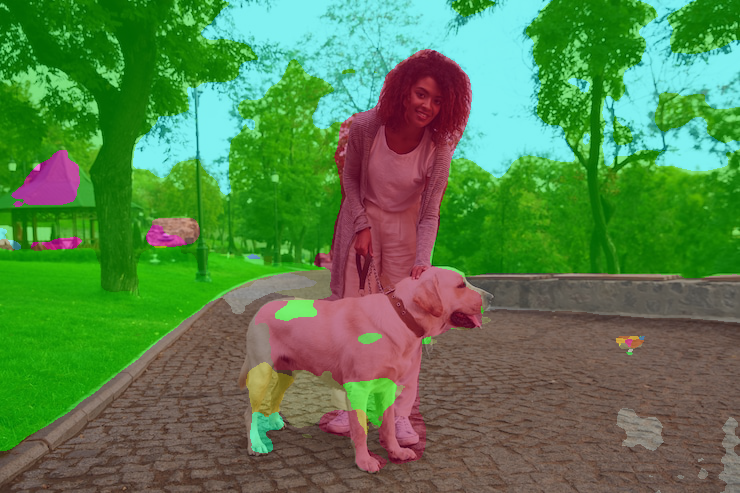

In [ ]:
import numpy as np

# Blend the original image and the predicted segmentation image
out = Image.blend(image, predicted_seg.convert("RGB"), alpha=0.5)